# <center>ADT dataset with trend and Seasonality Factors added</center>

### Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4956577/
'Each year, patients transferred between acute care hospitals constitute approximately 3.5% of all hospital inpatient admissions'

### Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import plotly.graph_objects as go

## Code to generate data from 2015 to 2020 based on MIMIC dataset.
MIMIC dataset for Admissions has been referenced to build data for ADT modelling.

In [2]:
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define the mode_of_arrival options
mode_of_arrival_options = ['Ambulance', 'Own Vehicle', 'Walk In', 'Other']

# Define the disposition options
disposition_options = ['HOME', 'ADMITTED', 'ELOPED', 'LEFT WITHOUT BEING SEEN', 'OTHER', 'LEFT AGAINST MEDICAL ADVICE', 'EXPIRED']

# Define the gender options
gender_options = ['M', 'F']

# Set a seed for reproducibility (optional)
random.seed(2020)

desired_total_count = 34730

# List of values specifying the number of IDs to generate for each month
original_num_ids_list = [15.42, 15.23, 15.30, 15.82, 15.77, 15.98, 15.72, 16.18, 16.27, 16.24, 16.07, 16.28]

# Calculate the total number of IDs generated in a year
total_ids_in_year = sum(original_num_ids_list)

# Define the scaling factor
scaling_factor = desired_total_count / total_ids_in_year

print('Scaling Factor:', scaling_factor)

# Calculate the scaled number of IDs for each month
num_ids_list = [int(original_num_ids * scaling_factor) for original_num_ids in original_num_ids_list]

# Define the start and end years, including a leap year
start_year = 2015
end_year = 2020

# Create an empty list to store data
data = []

# Initialize a linear trend factor
linear_trend_factor = 1

# Loop through each year
for year in range(start_year, end_year + 1):
    # Introduce a random percentage increase between 20% and 50%
    percentage_increase = random.uniform(0.30, 0.50)
    print('% increase:', percentage_increase)
    num_ids_list_with_increase = [int(num_ids * (1 + percentage_increase)) for num_ids in num_ids_list]

    # Apply the linear trend factor
    num_ids_list_with_trend = [int(num_ids * linear_trend_factor) for num_ids in num_ids_list_with_increase]

    # Adjust the linear trend factor for the next year (you can customize this)
    linear_trend_factor += 0.05  # Adjust the trend factor as needed

    # Determine if the current year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

    # Calculate the number of patients with 'Transfer_date' for the current year
    total_admissions = sum(num_ids_list_with_trend)
    num_transfer_patients = int(total_admissions * 0.035)

    # Calculate the number of transfer patients for the current year
    num_transfer_patients_yearly = int(total_admissions * 0.035)

    # Spread out transfer patients throughout the year
    transfer_month_distribution = [int(num_transfer_patients_yearly / 12)] * 12
    remaining_transfers = num_transfer_patients_yearly % 12

    # Distribute the remaining transfer patients randomly across the months
    for _ in range(remaining_transfers):
        random_month = random.randint(0, 11)
        transfer_month_distribution[random_month] += 1

    # Loop through each month
    for month, num_ids in enumerate(num_ids_list_with_trend, start=1):
        # Introduce seasonality by varying the number of IDs based on the month
        seasonality_factor = 1 + np.sin(2 * np.pi * (month - 1) / 12)  # Adjust the seasonality factor as needed
        num_ids = int(num_ids * seasonality_factor)

        # Generate random IDs, start dates, end dates, mode_of_arrival, and disposition for the current month
        for _ in range(num_ids):
            day = random.randint(1, 28)  # Generate a random day within the month
            start_date = datetime(year, month, day)
            end_date = start_date + timedelta(days=random.randint(1, 30))  # Generate a random end date within 30 days
            id_value = random.randint(1000000, 99999999)  # Generate 8 digits Patient IDs
            arrival_mode = random.choice(mode_of_arrival_options)
            gender = random.choice(gender_options)

            # Determine if this patient should have a 'Transfer_date'
            if transfer_month_distribution[month - 1] > 0:
                transfer_date = start_date
                transfer_month_distribution[month - 1] -= 1
                disposition = 'TRANSFER'
            else:
                transfer_date = None
                disposition = random.choice(disposition_options)

            if transfer_date == start_date:
                transfer_type = 'Transfer Admissions/Incoming Transfers'
            else:
                transfer_type = ''

            data.append([start_date, end_date, transfer_date, id_value, arrival_mode, disposition, transfer_type, gender])

# Create a Pandas DataFrame from the data
master_data = pd.DataFrame(data, columns=["Admission Date", "Discharge Date", "Transfer Date", "Patient ID", "Mode of Arrival", "Disposition", "Transfer Type", "Gender"])

master_data.to_csv('ADT dataset V3.csv')

# Assuming 'master_data' is your DataFrame
# Convert the 'Admission Date' column to datetime if it's not already
master_data['Admission Date'] = pd.to_datetime(master_data['Admission Date'])

# Extract the year from the 'Admission Date' column
master_data['Year'] = master_data['Admission Date'].dt.year

# Group by year and count admissions
yearly_admissions = master_data.groupby('Year')['Patient ID'].count()

yearly_admissions_percentage_increase = yearly_admissions.pct_change() * 100

print(yearly_admissions)
# Print the results
print(yearly_admissions_percentage_increase)

Scaling Factor: 182.5204961109943
% increase: 0.4239338541321323
% increase: 0.3074988430156789
% increase: 0.3708261589685712
% increase: 0.4976813389239167
% increase: 0.3975210925249858
% increase: 0.4219594918201598
Year
2015    48878
2016    47117
2017    51754
2018    59118
2019    57559
2020    61011
Name: Patient ID, dtype: int64
Year
2015          NaN
2016    -3.602848
2017     9.841458
2018    14.228852
2019    -2.637099
2020     5.997324
Name: Patient ID, dtype: float64


In [3]:
master_data['Admission Date'] = pd.to_datetime(master_data['Admission Date'])

# Extract the year from the 'Admission Date' column
master_data['Year'] = master_data['Admission Date'].dt.year

# Group by year and count admissions
yearly_admissions = master_data.groupby('Year')['Patient ID'].count()

yearly_admissions

Year
2015    48878
2016    47117
2017    51754
2018    59118
2019    57559
2020    61011
Name: Patient ID, dtype: int64

In [4]:
master_data.groupby('Admission Date')['Patient ID'].count()

Admission Date
2015-01-01    135
2015-01-02    156
2015-01-03    138
2015-01-04    143
2015-01-05    151
             ... 
2020-12-24     96
2020-12-25    104
2020-12-26     98
2020-12-27     87
2020-12-28    105
Name: Patient ID, Length: 1848, dtype: int64

In [5]:
data = master_data.groupby(master_data["Admission Date"])["Patient ID"].count().reset_index()
data.columns = ["Admission Date", "value"]
df = data["value"]
df.name = "value"
df

0       135
1       156
2       138
3       143
4       151
       ... 
1843     96
1844    104
1845     98
1846     87
1847    105
Name: value, Length: 1848, dtype: int64

In [6]:
import pandas as pd

# Assuming you have the DataFrame df
df_series = data["value"]

# Assign the Series the name "value"
df_series.name = "value"

# Now you can reference it as df.value
print(df_series)


0       135
1       156
2       138
3       143
4       151
       ... 
1843     96
1844    104
1845     98
1846     87
1847    105
Name: value, Length: 1848, dtype: int64


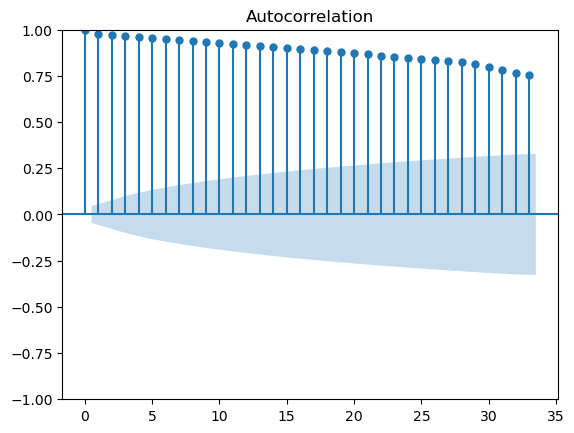

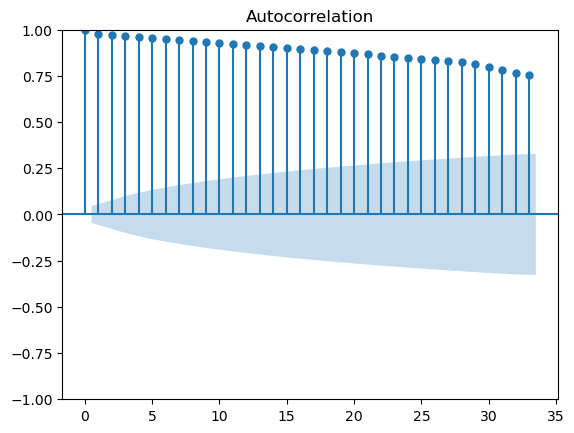

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_series)

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_series.dropna())
print('p-value original:', result[1])

result = adfuller(df_series.diff().dropna())
print('p-value 1st differencing:', result[1])

result = adfuller(df_series.diff().diff().dropna())
print('p-value 2nd differencing:', result[1])

p-value original: 0.17958724694002082
p-value 1st differencing: 0.0
p-value 2nd differencing: 1.989109706868693e-27


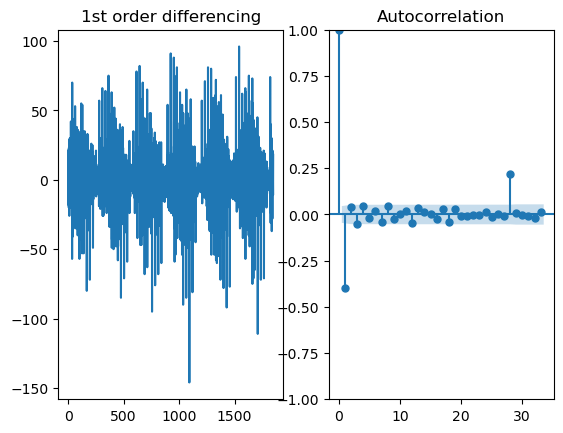

In [9]:
import matplotlib.pyplot as plt
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(df_series.diff())

ax2 = f.add_subplot(122)
plot_acf(df_series.diff().dropna(), ax= ax2)
plt.show()

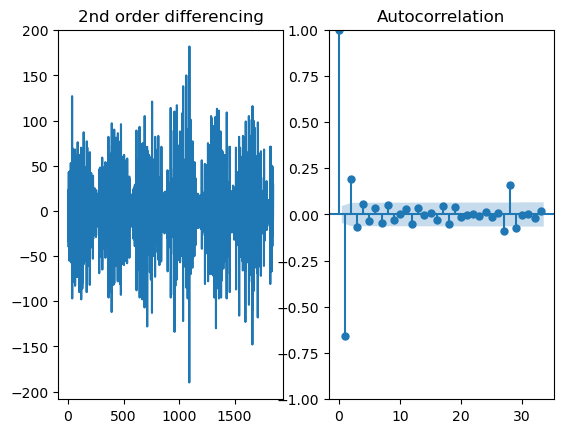

In [10]:
import matplotlib.pyplot as plt
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(df_series.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df_series.diff().diff().dropna(), ax= ax2)
plt.show()

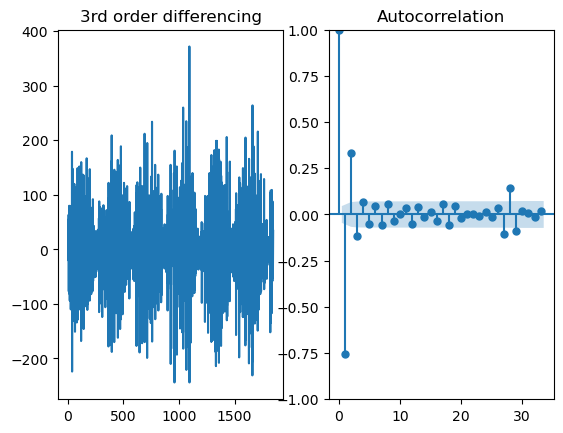

In [11]:
import matplotlib.pyplot as plt
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(df_series.diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df_series.diff().diff().diff().dropna(), ax= ax2)
plt.show()

In [12]:

arima_model = ARIMA(df_series, order=(1,1,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1848
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -8216.181
Date:                Wed, 08 Nov 2023   AIC                          16440.362
Time:                        05:52:35   BIC                          16462.447
Sample:                             0   HQIC                         16448.504
                               - 1848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8039      0.168     -4.788      0.000      -1.133      -0.475
ma.L1          0.3285      0.171      1.918      0.055      -0.007       0.664
ma.L2         -0.3425      0.090     -3.786      0.0

## Choosing the below model

In [13]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_series, order=(0,1,1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1848
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -8218.355
Date:                Wed, 08 Nov 2023   AIC                          16440.711
Time:                        05:52:35   BIC                          16451.754
Sample:                             0   HQIC                         16444.782
                               - 1848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4634      0.016    -29.108      0.000      -0.495      -0.432
sigma2       428.8525      8.077     53.093      0.000     413.021     444.684
Ljung-Box (L1) (Q):                   0.14   Jarque-

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_series, order=(0,2,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1848
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -8215.653
Date:                Wed, 08 Nov 2023   AIC                          16437.306
Time:                        05:52:36   BIC                          16453.868
Sample:                             0   HQIC                         16443.412
                               - 1848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4767      0.017    -89.128      0.000      -1.509      -1.444
ma.L2          0.4890      0.017     28.542      0.000       0.455       0.523
sigma2       428.6485      9.017     47.538      0.0

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_series, order=(1,2,2))
model = arima_model.fit()
print(model.summary())

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1848
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -8215.558
Date:                Wed, 08 Nov 2023   AIC                          16439.116
Time:                        05:52:37   BIC                          16461.199
Sample:                             0   HQIC                         16447.257
                               - 1848                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0239      0.046      0.519      0.604      -0.066       0.114
ma.L1         -1.4962      0.043    -34.612      0.000      -1.581      -1.412
ma.L2          0.5084      0.043     11.750      0.0

In [16]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have already defined 'df_series'

# Fit the ARIMA model
arima_model = ARIMA(df_series, order=(0, 2, 2))
model = arima_model.fit()

# Forecast the next 20 data points
forecast_steps = 20
forecast = model.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Values:")
print(forecast)

Forecasted Values:
1848    100.087071
1849    100.654557
1850    101.222043
1851    101.789529
1852    102.357014
1853    102.924500
1854    103.491986
1855    104.059472
1856    104.626957
1857    105.194443
1858    105.761929
1859    106.329415
1860    106.896901
1861    107.464386
1862    108.031872
1863    108.599358
1864    109.166844
1865    109.734329
1866    110.301815
1867    110.869301
Name: predicted_mean, dtype: float64


In [17]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have 'df_series' as a regular Pandas Series without a DateTime index

# Fit the ARIMA model
arima_model = ARIMA(df_series, order=(1,2,2))
model = arima_model.fit()

# Forecast the next 20 data points
forecast_steps = 20
forecast = model.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Values:")
print(forecast)

# If you want to append these forecasts to your original series, you can do the following:
import pandas as pd

# Create an integer-based index for the forecasted values
forecast_index = range(len(df_series), len(df_series) + forecast_steps)

# Create a Pandas Series with the forecasted values and the integer index
forecast_series = pd.Series(forecast, index=forecast_index)

# Append the forecasted series to the original series
extended_df_series = round(df_series.append(forecast_series),0)

# Print the extended series with forecasts
print("Extended Series:")
print(extended_df_series)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecasted Values:
1848    100.307242
1849    100.782571
1850    101.381422
1851    101.983226
1852    102.585100
1853    103.186975
1854    103.788851
1855    104.390727
1856    104.992602
1857    105.594478
1858    106.196354
1859    106.798229
1860    107.400105
1861    108.001981
1862    108.603856
1863    109.205732
1864    109.807608
1865    110.409483
1866    111.011359
1867    111.613235
Name: predicted_mean, dtype: float64
Extended Series:
0       135.0
1       156.0
2       138.0
3       143.0
4       151.0
        ...  
1863    109.0
1864    110.0
1865    110.0
1866    111.0
1867    112.0
Length: 1868, dtype: float64


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\2250785013.py:28: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_df_series = round(df_series.append(forecast_series),0)


## Choosing this version of order - 0,2,2

In [18]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have 'df_series' as a regular Pandas Series without a DateTime index

# Fit the ARIMA model
arima_model = ARIMA(df_series, order=(0,2,2))
model = arima_model.fit()

# Forecast the next 20 data points
forecast_steps = 20
forecast = model.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Values:")
print(forecast)

# If you want to append these forecasts to your original series, you can do the following:
import pandas as pd

# Create an integer-based index for the forecasted values
forecast_index = range(len(df_series), len(df_series) + forecast_steps)

# Create a Pandas Series with the forecasted values and the integer index
forecast_series = pd.Series(forecast, index=forecast_index)

# Append the forecasted series to the original series
extended_df_series = round(df_series.append(forecast_series),0)

# Print the extended series with forecasts
print("Extended Series:")
print(extended_df_series)

Forecasted Values:
1848    100.087071
1849    100.654557
1850    101.222043
1851    101.789529
1852    102.357014
1853    102.924500
1854    103.491986
1855    104.059472
1856    104.626957
1857    105.194443
1858    105.761929
1859    106.329415
1860    106.896901
1861    107.464386
1862    108.031872
1863    108.599358
1864    109.166844
1865    109.734329
1866    110.301815
1867    110.869301
Name: predicted_mean, dtype: float64
Extended Series:
0       135.0
1       156.0
2       138.0
3       143.0
4       151.0
        ...  
1863    109.0
1864    109.0
1865    110.0
1866    110.0
1867    111.0
Length: 1868, dtype: float64


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\2197297403.py:28: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_df_series = round(df_series.append(forecast_series),0)


In [19]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have 'df_series' as a regular Pandas Series without a DateTime index

# Fit the ARIMA model
arima_model = ARIMA(df_series, order=(1,2,2))
model = arima_model.fit()

# Forecast the next 20 data points
forecast_steps = 20
forecast = model.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Values:")
print(forecast)

# If you want to append these forecasts to your original series, you can do the following:
import pandas as pd

# Create an integer-based index for the forecasted values
forecast_index = range(len(df_series), len(df_series) + forecast_steps)

# Create a Pandas Series with the forecasted values and the integer index
forecast_series = pd.Series(forecast, index=forecast_index)

# Append the forecasted series to the original series
extended_df_series = round(df_series.append(forecast_series),0)

# Print the extended series with forecasts
print("Extended Series:")
print(extended_df_series)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecasted Values:
1848    100.307242
1849    100.782571
1850    101.381422
1851    101.983226
1852    102.585100
1853    103.186975
1854    103.788851
1855    104.390727
1856    104.992602
1857    105.594478
1858    106.196354
1859    106.798229
1860    107.400105
1861    108.001981
1862    108.603856
1863    109.205732
1864    109.807608
1865    110.409483
1866    111.011359
1867    111.613235
Name: predicted_mean, dtype: float64
Extended Series:
0       135.0
1       156.0
2       138.0
3       143.0
4       151.0
        ...  
1863    109.0
1864    110.0
1865    110.0
1866    111.0
1867    112.0
Length: 1868, dtype: float64


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\2250785013.py:28: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_df_series = round(df_series.append(forecast_series),0)


In [20]:
pd.Series(model.forecast(20))

1848    100.307242
1849    100.782571
1850    101.381422
1851    101.983226
1852    102.585100
1853    103.186975
1854    103.788851
1855    104.390727
1856    104.992602
1857    105.594478
1858    106.196354
1859    106.798229
1860    107.400105
1861    108.001981
1862    108.603856
1863    109.205732
1864    109.807608
1865    110.409483
1866    111.011359
1867    111.613235
Name: predicted_mean, dtype: float64

In [21]:
# ALl Data
data = master_data
data = data.groupby('Admission Date')['Patient ID'].count().reset_index()
data.columns = ['Admission Date', 'Patient Count']
data.head()

,Admission Date,Patient Count
0,2015-01-01,135
1,2015-01-02,156
2,2015-01-03,138
3,2015-01-04,143
4,2015-01-05,151


In [22]:
# Assuming 'master_data' is your DataFrame
# Convert the 'Admission Date' column to a datetime object if it's not already
master_data['Admission Date'] = pd.to_datetime(master_data['Admission Date'])

# Group the data by year and month, and sum the patient counts within each group
year_month_data = master_data.groupby(master_data['Admission Date'].dt.to_period('M'))['Patient ID'].count().reset_index()

# Rename the columns
year_month_data.columns = ['year_month_admission_date', 'Patient Count']

year_month_data.head()


,year_month_admission_date,Patient Count
0,2015-01,4006
1,2015-02,5935
2,2015-03,7417
3,2015-04,8220
4,2015-05,7646


## Test & Train Split

In [23]:
# Training dataset:
training_data = master_data[(master_data['Admission Date'] >= '2015-01-01') & (master_data['Admission Date'] <= '2020-06-30')]
train_data = training_data.groupby(training_data["Admission Date"])["Patient ID"].count().reset_index()
train_data.columns = ["Admission Date", "patient_count"]
print('Training data:\n',train_data.head(10))
train_df = train_data["patient_count"]
train_df.name = "patient_count"
print('\n Training data count:\n',train_df)


# Testng dataset:
testing_data = master_data[(master_data['Admission Date'] >= '2020-07-01') & (master_data['Admission Date'] <= '2020-12-15')]
test_data = testing_data.groupby(testing_data["Admission Date"])["Patient ID"].count().reset_index()
test_data.columns = ["Admission Date", "patient_count"]
print('Testing data:\n',test_data.head(10))
test_df = test_data["patient_count"]
test_df.name = "patient_count"
print('\n Testing data count:\n',test_df)

Training data:
   Admission Date  patient_count
0     2015-01-01            135
1     2015-01-02            156
2     2015-01-03            138
3     2015-01-04            143
4     2015-01-05            151
5     2015-01-06            143
6     2015-01-07            123
7     2015-01-08            146
8     2015-01-09            135
9     2015-01-10            138

 Training data count:
 0       135
1       156
2       138
3       143
4       151
       ... 
1703    269
1704    253
1705    298
1706    274
1707    281
Name: patient_count, Length: 1708, dtype: int64
Testing data:
   Admission Date  patient_count
0     2020-07-01            170
1     2020-07-02            157
2     2020-07-03            184
3     2020-07-04            180
4     2020-07-05            182
5     2020-07-06            162
6     2020-07-07            191
7     2020-07-08            158
8     2020-07-09            189
9     2020-07-10            200

 Testing data count:
 0      170
1      157
2      184
3    

In [24]:
year_month_data = training_data.groupby(training_data['Admission Date'].dt.to_period('M'))['Patient ID'].count().reset_index()

# Rename the columns
year_month_data.columns = ['Year-Month', 'Patient Count']

print(year_month_data.head())

year_month_data = testing_data.groupby(testing_data['Admission Date'].dt.to_period('M'))['Patient ID'].count().reset_index()

# Rename the columns
year_month_data.columns = ['Year-Month', 'Patient Count']

print(year_month_data.head())

  Year-Month  Patient Count
0    2015-01           4006
1    2015-02           5935
2    2015-03           7417
3    2015-04           8220
4    2015-05           7646
  Year-Month  Patient Count
0    2020-07           5098
1    2020-08           2624
2    2020-09            706
3    2020-11            698
4    2020-12           1449


In [25]:
train_data = train_df
test_data = test_df
arima_model = ARIMA(train_data, order=(0, 2, 2))
model = arima_model.fit()

# Forecast using the model
forecast_steps = len(test_data)  # Forecast for the remaining 20% of the data
forecast = model.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Values:")
print(forecast)

Forecasted Values:
1708    277.843134
1709    277.197307
1710    276.551480
1711    275.905652
1712    275.259825
           ...    
1830    199.052205
1831    198.406378
1832    197.760551
1833    197.114723
1834    196.468896
Name: predicted_mean, Length: 127, dtype: float64


In [26]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_data, order=(0,2,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:          patient_count   No. Observations:                 1708
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -7599.657
Date:                Wed, 08 Nov 2023   AIC                          15205.314
Time:                        05:52:42   BIC                          15221.640
Sample:                             0   HQIC                         15211.357
                               - 1708                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4967      0.017    -86.158      0.000      -1.531      -1.463
ma.L2          0.5089      0.018     28.413      0.000       0.474       0.544
sigma2       432.1149      9.697     44.560      0.0

In [27]:
y_pred= forecast
y_pred = y_pred.reset_index(drop=True)
y_true = test_data

In [28]:
## Mean Absolute Percentage Error
mape = np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
## Mean Absolute Error
mae = np.mean(np.abs(y_pred-y_true))
## Mean Percentage Error
mpe = np.mean((y_pred-y_true)/y_true)
## Root Mean Square Error
rmse = np.mean((y_pred-y_true)**2)**0.5
## Correlation Coefficient
corr = np.corrcoef(y_pred,y_true)[0,1]


mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
minmax = 1 - np.mean(mins/maxs)



# Assuming 'y_pred' and 'y_true' are your predicted and true values
r2 = r2_score(y_true, y_pred)

print(f'R-squared (R²): {r2:.2f}')


import pprint
pprint.pprint({'mape':mape, 'mae':mae, 'mpe':mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax })

R-squared (R²): -5.89
{'corr': 0.6926874001622912,
 'mae': 153.88829860270846,
 'mape': 4.272772035197136,
 'minmax': 0.6621447634156505,
 'mpe': 4.272772035197136,
 'rmse': 161.24859416311088}


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1995283924.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1995283924.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)


In [ ]:
train_data = train_df
test_data = test_df
arima_model = ARIMA(train_data, order=(1, 2, 2))
model = arima_model.fit()
print(model.summary())

# Forecast using the model
forecast_steps = len(test_data)  # Forecast for the remaining 20% of the data
forecast = model.forecast(steps=forecast_steps)

# Print the forecasted values
print("Forecasted Values:")
print(forecast)

In [30]:
y_pred= forecast
y_pred = y_pred.reset_index(drop=True)
y_true = test_data

In [31]:
## Mean Absolute Percentage Error
mape = np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
## Mean Absolute Error
mae = np.mean(np.abs(y_pred-y_true))
## Mean Percentage Error
mpe = np.mean((y_pred-y_true)/y_true)
## Root Mean Square Error
rmse = np.mean((y_pred-y_true)**2)**0.5
## Correlation Coefficient
corr = np.corrcoef(y_pred,y_true)[0,1]


mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
minmax = 1 - np.mean(mins/maxs)

r2 = r2_score(y_true, y_pred)

print(f'R-squared (R²): {r2:.2f}')
print()

import pprint
pprint.pprint({'mape':mape, 'mae':mae, 'mpe':mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax })

R-squared (R²): -5.76

{'corr': 0.6926914679048549,
 'mae': 152.35214037838716,
 'mape': 4.22968872559964,
 'minmax': 0.6602941174588969,
 'mpe': 4.22968872559964,
 'rmse': 159.68892772912207}


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\3176238655.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\3176238655.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)


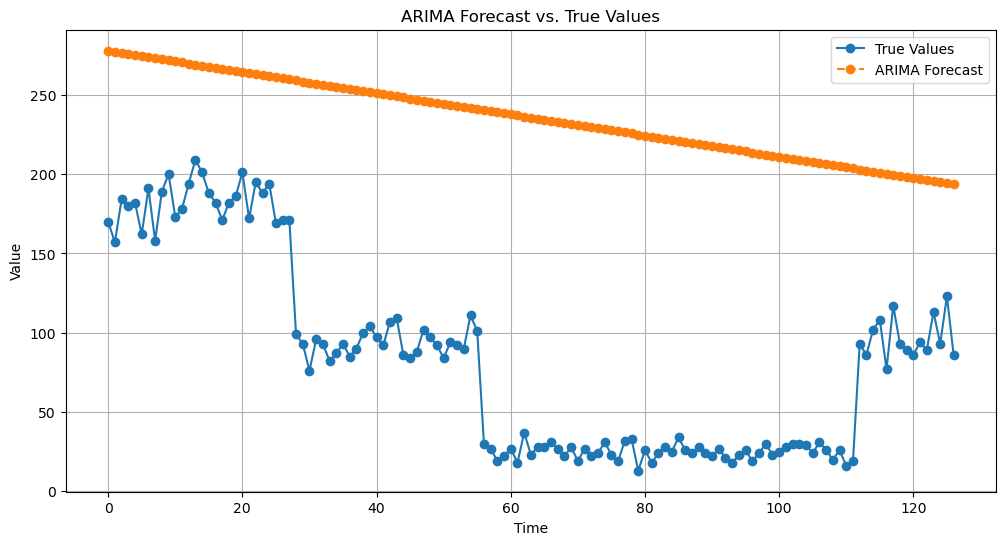

In [32]:
import matplotlib.pyplot as plt

# Assuming 'y_true' is your true values, 'y_pred' is your ARIMA model's predictions, and 'dates' is a list of date values
# 'y_pred' and 'y_true' should be of the same length

# Create a time series plot
x_values = range(len(y_true))

plt.figure(figsize=(12, 6))
plt.plot(x_values, y_true, label='True Values', marker='o', linestyle='-')
plt.plot(x_values, y_pred, label='ARIMA Forecast', marker='o', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecast vs. True Values')
plt.legend()
plt.grid(True)
plt.show()

# Splitting into train and Test

In [33]:
# Training dataset:
training_data = master_data[(master_data['Admission Date'] >= '2015-01-01') & (master_data['Admission Date'] <= '2020-11-30')]
train_data = training_data.groupby(training_data["Admission Date"])["Patient ID"].count().reset_index()
train_data.columns = ["Admission Date", "patient_count"]
print('Training data:\n',train_data.head(10))
train_df = train_data["patient_count"]
train_df.name = "patient_count"
print('\n Training data count:\n',train_df)


# Testng dataset:
testing_data = master_data[(master_data['Admission Date'] >= '2020-12-01') & (master_data['Admission Date'] <= '2020-12-31')]
test_data = testing_data.groupby(testing_data["Admission Date"])["Patient ID"].count().reset_index()
test_data.columns = ["Admission Date", "patient_count"]
print('Testing data:\n',test_data.head(10))
test_df = test_data["patient_count"]
test_df.name = "patient_count"
print('\n Testing data count:\n',test_df)

Training data:
   Admission Date  patient_count
0     2015-01-01            135
1     2015-01-02            156
2     2015-01-03            138
3     2015-01-04            143
4     2015-01-05            151
5     2015-01-06            143
6     2015-01-07            123
7     2015-01-08            146
8     2015-01-09            135
9     2015-01-10            138

 Training data count:
 0       135
1       156
2       138
3       143
4       151
       ... 
1815     26
1816     20
1817     26
1818     16
1819     19
Name: patient_count, Length: 1820, dtype: int64
Testing data:
   Admission Date  patient_count
0     2020-12-01             93
1     2020-12-02             86
2     2020-12-03            102
3     2020-12-04            108
4     2020-12-05             77
5     2020-12-06            117
6     2020-12-07             93
7     2020-12-08             89
8     2020-12-09             86
9     2020-12-10             94

 Testing data count:
 0      93
1      86
2     102
3     10

In [34]:
train_data = train_df
test_data = test_df

In [35]:
test_df

0      93
1      86
2     102
3     108
4      77
5     117
6      93
7      89
8      86
9      94
10     89
11    113
12     93
13    123
14     86
15     91
16     77
17     92
18     84
19     95
20     67
21     88
22    106
23     96
24    104
25     98
26     87
27    105
Name: patient_count, dtype: int64

In [36]:
# Import necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

train_data = train_df
test_data = test_df

# Load your time series data into a pandas DataFrame
# Replace 'your_data.csv' with your data file
#data = pd.read_csv('ADT datset V1.csv')
#data['Date'] = pd.to_datetime(data['Date'])  # Make sure the 'Date' column is in datetime format
#data.set_index('Date', inplace=True)  # Set 'Date' as the index

data = train_data

# Define the order of the SARIMA model (p, d, q), (P, D, Q, S)
# p: AutoRegressive order
# d: Differencing order
# q: Moving Average order
# P: Seasonal AutoRegressive order
# D: Seasonal Differencing order
# Q: Seasonal Moving Average order
# S: Seasonal period (e.g., 12 for monthly data with yearly seasonality)
p, d, q = 2, 2, 1
P, D, Q, S = 3, 3, 3, 12

# Fit the SARIMAX model to your data
model = sm.tsa.SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

# Generate forecasts for future time periods
forecast_periods = 50  # Change this to the number of periods you want to forecast
forecast = results.get_forecast(steps=forecast_periods)

# Extract forecasted values and associated confidence intervals
forecast_mean = np.ceil(forecast.predicted_mean)
forecast_ci = round(forecast.conf_int(),2)


# Print the forecasted values for the next 50 days
print("Forecasted Values for the Next 50 Days:")
print(len(forecast_mean))

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasted Values for the Next 50 Days:
50


In [37]:
print(len(forecast_mean))

50


In [38]:
forecast_mean

1820     49.0
1821     61.0
1822     51.0
1823     29.0
1824     89.0
1825     85.0
1826     85.0
1827     75.0
1828     66.0
1829     83.0
1830     68.0
1831     64.0
1832     88.0
1833    110.0
1834     90.0
1835     73.0
1836    144.0
1837    155.0
1838    153.0
1839    131.0
1840     95.0
1841    118.0
1842     89.0
1843     92.0
1844    121.0
1845    139.0
1846    114.0
1847     93.0
1848    229.0
1849    231.0
1850    237.0
1851    202.0
1852    182.0
1853    207.0
1854    170.0
1855    174.0
1856    201.0
1857    226.0
1858    194.0
1859    176.0
1860    331.0
1861    339.0
1862    350.0
1863    300.0
1864    260.0
1865    289.0
1866    235.0
1867    247.0
1868    272.0
1869    297.0
Name: predicted_mean, dtype: float64

In [63]:
# Define the start and end dates
start_date = datetime(2020, 12, 1)
end_date = datetime(2021, 1, 19)

# Create a list of dates from start_date to end_date
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Create a DataFrame from the list of dates
forecast_date_df = pd.DataFrame({'Date': date_list})

# Print the first few rows of the DataFrame
print(forecast_date_df.head(), '\n', forecast_date_df.tail())

        Date
0 2020-12-01
1 2020-12-02
2 2020-12-03
3 2020-12-04
4 2020-12-05 
          Date
45 2021-01-15
46 2021-01-16
47 2021-01-17
48 2021-01-18
49 2021-01-19


In [60]:
forecast_mean_reset = forecast_mean.reset_index(drop=True)
forecast_mean_reset

0                                                  49.0
1                                                  61.0
2                                                  51.0
3                                                  29.0
4                                                  89.0
5                                                  85.0
6                                                  85.0
7                                                  75.0
8                                                  66.0
9                                                  83.0
10                                                 68.0
11                                                 64.0
12                                                 88.0
13                                                110.0
14                                                 90.0
15                                                 73.0
16                                                144.0
17                                              

In [41]:
forecast_ci =forecast_ci.reset_index(drop=True)
forecast_ci

,lower patient_count,upper patient_count
0,-14.10,111.54
1,-11.39,131.72
2,-31.24,131.86
3,-62.65,119.74
4,-10.79,188.00
5,-22.57,191.74
6,-29.52,199.30
7,-46.89,195.61
8,-61.94,193.57
9,-51.88,216.06


In [80]:
# Reset the index for both DataFrames to ensure alignment
forecast_date_df = forecast_date_df.reset_index(drop=True)
forecast_date_df['forecast_patient_count'] = forecast_mean_reset

# Add the 'forecast_patient_count' column to the 'forecast_date_df' DataFrame
forecast_date_df['lower patient_count'] = forecast_ci['lower patient_count']
forecast_date_df['upper patient_count'] = forecast_ci['upper patient_count']

forecast_date_df.head()

,Date,forecast_patient_count,lower patient_count,upper patient_count
0,2020-12-01,49.0,-14.10,111.54
1,2020-12-02,61.0,-11.39,131.72
2,2020-12-03,51.0,-31.24,131.86
3,2020-12-04,29.0,-62.65,119.74
4,2020-12-05,89.0,-10.79,188.00


In [43]:
y_pred= forecast_mean_reset[0:28]
y_pred = y_pred.reset_index(drop=True)
y_true = test_data

In [44]:
y_true

0      93
1      86
2     102
3     108
4      77
5     117
6      93
7      89
8      86
9      94
10     89
11    113
12     93
13    123
14     86
15     91
16     77
17     92
18     84
19     95
20     67
21     88
22    106
23     96
24    104
25     98
26     87
27    105
Name: patient_count, dtype: int64

In [45]:
## Mean Absolute Percentage Error
mape = np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
## Mean Absolute Error
mae = np.mean(np.abs(y_pred-y_true))
## Mean Percentage Error
mpe = np.mean((y_pred-y_true)/y_true)
## Root Mean Square Error
rmse = np.mean((y_pred-y_true)**2)**0.5
## Correlation Coefficient
corr = np.corrcoef(y_pred,y_true)[0,1]


mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
minmax = 1 - np.mean(mins/maxs)

import pprint
pprint.pprint({'mape':mape, 'mae':mae, 'mpe':mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax })

print('\n Avg. Mean Absolute Percentage Error = {:.2f}%'.format(round(mape*100,2)))
print(' Accurary = {:.2f}%'.format(100-round(mape*100,2)))

{'corr': -0.1933163516209619,
 'mae': 29.178571428571427,
 'mape': 0.3147683308975215,
 'minmax': 0.25724809969138984,
 'mpe': 0.014420058679841726,
 'rmse': 35.89418974072067}

 Avg. Mean Absolute Percentage Error = 31.48%
 Accurary = 68.52%


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1830689010.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1830689010.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)


In [81]:
# Define the start and end dates
start_date = datetime(2015, 1, 1)
end_date = datetime(2021, 1, 19)

# Create a list of dates from start_date to end_date
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Create a DataFrame from the list of dates
date_df = pd.DataFrame({'Date': date_list})


# Print the first few rows of the DataFrame
print(date_df.head(), '\n', date_df.tail())

        Date
0 2015-01-01
1 2015-01-02
2 2015-01-03
3 2015-01-04
4 2015-01-05 
            Date
2206 2021-01-15
2207 2021-01-16
2208 2021-01-17
2209 2021-01-18
2210 2021-01-19


In [82]:
admissions_data1 = master_data.groupby('Admission Date')['Patient ID'].count().reset_index()
admissions_data1.columns = ['Date','Patient_Count']
admissions_data1.tail(50)

,Date,Patient_Count
1798,2020-11-07,22
1799,2020-11-08,27
1800,2020-11-09,21
1801,2020-11-10,18
1802,2020-11-11,23
1803,2020-11-12,26
1804,2020-11-13,19
1805,2020-11-14,24
1806,2020-11-15,30
1807,2020-11-16,23


In [83]:
merged_df1 = pd.merge(date_df, admissions_data1, on='Date', how='left')
merged_df1.tail(50)

,Date,Patient_Count
2161,2020-12-01,93.0
2162,2020-12-02,86.0
2163,2020-12-03,102.0
2164,2020-12-04,108.0
2165,2020-12-05,77.0
2166,2020-12-06,117.0
2167,2020-12-07,93.0
2168,2020-12-08,89.0
2169,2020-12-09,86.0
2170,2020-12-10,94.0


In [84]:
merged_df1 = pd.merge(merged_df1,forecast_date_df,on='Date',how = 'left')
merged_df1.tail(50)

,Date,Patient_Count,forecast_patient_count,lower patient_count,upper patient_count
2161,2020-12-01,93.0,49.0,-14.10,111.54
2162,2020-12-02,86.0,61.0,-11.39,131.72
2163,2020-12-03,102.0,51.0,-31.24,131.86
2164,2020-12-04,108.0,29.0,-62.65,119.74
2165,2020-12-05,77.0,89.0,-10.79,188.00
2166,2020-12-06,117.0,85.0,-22.57,191.74
2167,2020-12-07,93.0,85.0,-29.52,199.30
2168,2020-12-08,89.0,75.0,-46.89,195.61
2169,2020-12-09,86.0,66.0,-61.94,193.57
2170,2020-12-10,94.0,83.0,-51.88,216.06


In [117]:
merged_df1.columns = ['Date',
                      'Admissions_Patient_Count','Admissions_Forecast_Patient_Count', 'Admissions_Lower_Bound','Admissions_Upper_Bound']
merged_df1.head()

,Date,Admissions_Patient_Count,Admissions_Forecast_Patient_Count,Admissions_Lower_Bound,Admissions_Upper_Bound
0,2015-01-01,135.0,NaN,NaN,NaN
1,2015-01-02,156.0,NaN,NaN,NaN
2,2015-01-03,138.0,NaN,NaN,NaN
3,2015-01-04,143.0,NaN,NaN,NaN
4,2015-01-05,151.0,NaN,NaN,NaN


In [121]:
# Create a Plotly figure
fig = go.Figure()

# Plot the last 15 values of the test data as a bar graph with only y-axis on hovering
fig.add_trace(go.Bar(x=merged_df1['Date'][2161:2188], y=merged_df1['Admissions_Patient_Count'].iloc[2161:2188], name='Test Data', marker_color='green', hoverinfo='x, y'))

#fig.add_trace(go.Scatter(x=merged_df1['Date'][2188:], y=merged_df1['lower patient_count'].iloc[2188:], fill='tozeroy', mode='lines', name='Forecast', line=dict(color='pink'), fillcolor='rgba(255, 192, 203, 0.5)',hoverinfo='name,x,y'))
#fig.add_trace(go.Scatter(x=merged_df1['Date'][2188:], y=merged_df1['upper patient_count'].iloc[2188:], fill='tozeroy', mode='lines', name='Forecast', line=dict(color='pink'), fillcolor='rgba(255, 192, 203, 0.5)', hoverinfo='name,x,y'))


# Plot the last 15 data points and the 50 forecasts
fig.add_trace(go.Scatter(x=merged_df1['Date'][2161:2188], y=merged_df1['Admissions_Patient_Count'].iloc[2161:2188], mode='lines+markers', name='Last 15 Data Points', line=dict(color='blue'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df1['Date'][2188:], y=merged_df1['Admissions_Forecast_Patient_Count'].iloc[2188:], mode='lines+markers', name='Forecast', line=dict(color='red'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df1['Date'][2161:2188], y=merged_df1['Admissions_Forecast_Patient_Count'].iloc[2161:2188], mode='lines+markers', name='Forecast', line=dict(color='orange'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df1['Date'][2176:2188], y=merged_df1['Admissions_Forecast_Patient_Count'].iloc[2176:2188], mode='lines+markers', name='Forecast', line=dict(color='pink'), hoverinfo='name,x,y'))

# Add a line shape to connect the blue and red lines

line_shape = {
    'type': 'line',
    'x0': merged_df1['Date'][2187],
    'x1': merged_df1['Date'][2188],
    'y0': merged_df1['Admissions_Forecast_Patient_Count'].iloc[2187],
    'y1': merged_df1['Admissions_Forecast_Patient_Count'].iloc[2188],
    'line': {'color': 'red', 'width': 2},
}
fig.add_shape(line_shape)

# Customize the layout
fig.update_layout(
    title='Patient Admission Forecast',
    xaxis_title='Date',
    yaxis_title='Patient Count',
    height=600,  # Adjust the height as needed
    width=1000   # Adjust the width as needed
)

fig.update_yaxes(
    tickvals=[100,200,300,400,500],
    #[200, 400, 600, 800,1000],  # Set the y-axis tick values
    tickmode='array'  # Use the specified tick values
)

# Show the interactive plot
fig.show()

In [135]:
# Create a Plotly figure
fig = go.Figure()

# Plot the last 15 values of the test data as a bar graph with only y-axis on hovering
fig.add_trace(go.Bar(x=merged_df1['Date'][2161:2188], y=merged_df1['Admissions_Patient_Count'].iloc[2161:2188], name='Test Data', marker_color='green', hoverinfo='x, y'))

fig.add_trace(go.Scatter(x=merged_df1['Date'][2188:], y=merged_df1['Admissions_Lower_Bound'].iloc[2188:]*0.4, fill='tozeroy', mode='lines', name='Forecast', line=dict(color='pink'), fillcolor='rgba(255, 192, 203, 0.5)',hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df1['Date'][2188:], y=merged_df1['Admissions_Upper_Bound'].iloc[2188:]*0.4, fill='tozeroy', mode='lines', name='Forecast', line=dict(color='pink'), fillcolor='rgba(255, 192, 203, 0.5)', hoverinfo='name,x,y'))


# Plot the last 15 data points and the 50 forecasts
fig.add_trace(go.Scatter(x=merged_df1['Date'][2161:2188], y=merged_df1['Admissions_Patient_Count'].iloc[2161:2188], mode='lines+markers', name='Last 15 Data Points', line=dict(color='blue'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df1['Date'][2188:], y=merged_df1['Admissions_Forecast_Patient_Count'].iloc[2188:], mode='lines+markers', name='Forecast', line=dict(color='red'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df1['Date'][2161:2188], y=merged_df1['Admissions_Forecast_Patient_Count'].iloc[2161:2188], mode='lines+markers', name='Forecast', line=dict(color='orange'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df1['Date'][2176:2188], y=merged_df1['Admissions_Forecast_Patient_Count'].iloc[2176:2188], mode='lines+markers', name='Forecast', line=dict(color='pink'), hoverinfo='name,x,y'))

# Add a line shape to connect the blue and red lines

line_shape = {
    'type': 'line',
    'x0': merged_df1['Date'][2187],
    'x1': merged_df1['Date'][2188],
    'y0': merged_df1['Admissions_Forecast_Patient_Count'].iloc[2187],
    'y1': merged_df1['Admissions_Forecast_Patient_Count'].iloc[2188],
    'line': {'color': 'red', 'width': 2},
}
fig.add_shape(line_shape)

# Customize the layout
fig.update_layout(
    title='Patient Admission Forecast',
    xaxis_title='Date',
    yaxis_title='Patient Count',
    height=600,  # Adjust the height as needed
    width=1000   # Adjust the width as needed
)

fig.update_yaxes(
    tickvals=[100,200,300,400,500], # Set the y-axis tick values
    tickmode='array'  # Use the specified tick values
)

# Show the interactive plot
fig.show()

# <center> Discharges </center>

In [3]:
master_data['Discharge Date'] = pd.to_datetime(master_data['Discharge Date'])

# Extract the year from the 'Admission Date' column
master_data['Year'] = master_data['Discharge Date'].dt.year

# Group by year and count admissions
yearly_admissions = master_data.groupby('Year')['Patient ID'].count()

yearly_admissions

Year
2015    47896
2016    47167
2017    51662
2018    58959
2019    57650
2020    60904
2021     1199
Name: Patient ID, dtype: int64

In [4]:
master_data.groupby('Discharge Date')['Patient ID'].count()

Discharge Date
2015-01-02    12
2015-01-03     7
2015-01-04    16
2015-01-05    16
2015-01-06    19
              ..
2021-01-22    29
2021-01-23    17
2021-01-24    15
2021-01-25    13
2021-01-26     3
Name: Patient ID, Length: 2185, dtype: int64

## Splitting into Train and Test

In [5]:
# Training dataset:
training_data_discharge = master_data[(master_data['Discharge Date'] >= '2015-01-01') & (master_data['Discharge Date'] <= '2020-11-30')]
train_data_discharge = training_data_discharge.groupby(training_data["Discharge Date"])["Patient ID"].count().reset_index()
train_data_discharge.columns = ["Discharge Date", "patient_count"]
print('Training data:\n',train_data_discharge.head(10))
train_df_discharge = train_data_discharge["patient_count"]
train_df_discharge.name = "patient_count"
print('\n Training data count:\n',train_df)


# Testng dataset:
testing_data_discharge = master_data[(master_data['Discharge Date'] >= '2020-12-01') & (master_data['Discharge Date'] <= '2020-12-31')]
test_data_discharge = testing_data_discharge.groupby(testing_data["Discharge Date"])["Patient ID"].count().reset_index()
test_data_discharge.columns = ["Discharge Date", "patient_count"]
print('Testing data:\n',test_data_discharge.tail(10))
test_df_discharge = test_data_discharge["patient_count"]
test_df_discharge.name = "patient_count"
print('\n Testing data count:\n',test_df)

NameError: name 'training_data' is not defined

In [102]:
# Import necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

train_data = train_df_discharge
test_data = test_df_discharge

# Load your time series data into a pandas DataFrame
# Replace 'your_data.csv' with your data file
#data = pd.read_csv('ADT datset V1.csv')
#data['Date'] = pd.to_datetime(data['Date'])  # Make sure the 'Date' column is in datetime format
#data.set_index('Date', inplace=True)  # Set 'Date' as the index

data = train_data

# Define the order of the SARIMA model (p, d, q), (P, D, Q, S)
# p: AutoRegressive order
# d: Differencing order
# q: Moving Average order
# P: Seasonal AutoRegressive order
# D: Seasonal Differencing order
# Q: Seasonal Moving Average order
# S: Seasonal period (e.g., 12 for monthly data with yearly seasonality)
p, d, q = 2, 2, 3
P, D, Q, S = 3, 3, 3, 12

# Fit the SARIMAX model to your data
model = sm.tsa.SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

# Generate forecasts for future time periods
forecast_periods = 50  # Change this to the number of periods you want to forecast
forecast = results.get_forecast(steps=forecast_periods)

# Extract forecasted values and associated confidence intervals
forecast_mean = np.ceil(forecast.predicted_mean)
forecast_ci = round(forecast.conf_int(),2)

# Print the forecasted values for the next 50 days
print("Forecasted Values for the Next 50 Days:")
print(len(forecast_mean))

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Forecasted Values for the Next 50 Days:
50


In [103]:
forecast_mean

2128     15.0
2129      7.0
2130     17.0
2131      9.0
2132     24.0
2133     14.0
2134     24.0
2135     27.0
2136     22.0
2137     33.0
2138     28.0
2139     33.0
2140     29.0
2141     25.0
2142     36.0
2143     30.0
2144     43.0
2145     37.0
2146     51.0
2147     49.0
2148     49.0
2149     59.0
2150     39.0
2151     52.0
2152     50.0
2153     41.0
2154     52.0
2155     42.0
2156     59.0
2157     60.0
2158     69.0
2159     71.0
2160     70.0
2161     75.0
2162     58.0
2163     65.0
2164     66.0
2165     61.0
2166     75.0
2167     67.0
2168     82.0
2169     89.0
2170     98.0
2171     99.0
2172    101.0
2173    107.0
2174     76.0
2175     89.0
2176     92.0
2177     86.0
Name: predicted_mean, dtype: float64

In [104]:
# Define the start and end dates
start_date = datetime(2020, 12, 1)
end_date = datetime(2021, 1, 19)

# Create a list of dates from start_date to end_date
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Create a DataFrame from the list of dates
forecast_date_df = pd.DataFrame({'Date': date_list})

# Print the first few rows of the DataFrame
print(forecast_date_df.head(), '\n', forecast_date_df.tail())

        Date
0 2020-12-01
1 2020-12-02
2 2020-12-03
3 2020-12-04
4 2020-12-05 
          Date
45 2021-01-15
46 2021-01-16
47 2021-01-17
48 2021-01-18
49 2021-01-19


In [105]:
# Reset the index for both DataFrames to ensure alignment
forecast_date_df = forecast_date_df.reset_index(drop=True)
forecast_mean = forecast_mean.reset_index(drop=True)

# Add the 'forecast_patient_count' column to the 'forecast_date_df' DataFrame
forecast_date_df['forecast_patient_count'] = forecast_mean
forecast_date_df

,Date,forecast_patient_count
0,2020-12-01,15.0
1,2020-12-02,7.0
2,2020-12-03,17.0
3,2020-12-04,9.0
4,2020-12-05,24.0
5,2020-12-06,14.0
6,2020-12-07,24.0
7,2020-12-08,27.0
8,2020-12-09,22.0
9,2020-12-10,33.0


In [106]:
forecast_mean_reset = forecast_mean.reset_index(drop=True)
forecast_mean_reset

0      15.0
1       7.0
2      17.0
3       9.0
4      24.0
5      14.0
6      24.0
7      27.0
8      22.0
9      33.0
10     28.0
11     33.0
12     29.0
13     25.0
14     36.0
15     30.0
16     43.0
17     37.0
18     51.0
19     49.0
20     49.0
21     59.0
22     39.0
23     52.0
24     50.0
25     41.0
26     52.0
27     42.0
28     59.0
29     60.0
30     69.0
31     71.0
32     70.0
33     75.0
34     58.0
35     65.0
36     66.0
37     61.0
38     75.0
39     67.0
40     82.0
41     89.0
42     98.0
43     99.0
44    101.0
45    107.0
46     76.0
47     89.0
48     92.0
49     86.0
Name: predicted_mean, dtype: float64

In [148]:
forecast_ci =forecast_ci.reset_index(drop=True)
forecast_ci

,lower patient_count,upper patient_count
0,-42.35,72.13
1,-53.72,67.28
2,-44.62,77.20
3,-52.70,69.27
4,-37.72,84.30
5,-47.90,74.13
6,-37.07,84.98
7,-34.32,87.74
8,-39.75,82.33
9,-28.62,93.47


In [149]:
# Reset the index for both DataFrames to ensure alignment
forecast_date_df = forecast_date_df.reset_index(drop=True)
forecast_date_df['Discharge_forecast_patient_count'] = forecast_mean_reset

# Add the 'forecast_patient_count' column to the 'forecast_date_df' DataFrame
forecast_date_df['Discharge_Lower_Bound'] = forecast_ci['lower patient_count']
forecast_date_df['Discharge_Upper_Bound'] = forecast_ci['upper patient_count']

forecast_date_df.head()

,Date,forecast_patient_count,Discharge_Lower_Bound,Discharge_Upper_Bound,Discharge_forecast_patient_count
0,2020-12-01,15.0,-42.35,72.13,15.0
1,2020-12-02,7.0,-53.72,67.28,7.0
2,2020-12-03,17.0,-44.62,77.20,17.0
3,2020-12-04,9.0,-52.70,69.27,9.0
4,2020-12-05,24.0,-37.72,84.30,24.0


In [107]:
y_pred= forecast_mean_reset[0:30]
y_pred = y_pred.reset_index(drop=True)
y_true = test_data

In [108]:
print(len(y_pred),len(y_true))

30 30


In [109]:
## Mean Absolute Percentage Error
mape = np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
## Mean Absolute Error
mae = np.mean(np.abs(y_pred-y_true))
## Mean Percentage Error
mpe = np.mean((y_pred-y_true)/y_true)
## Root Mean Square Error
rmse = np.mean((y_pred-y_true)**2)**0.5
## Correlation Coefficient
corr = np.corrcoef(y_pred,y_true)[0,1]


mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
minmax = 1 - np.mean(mins/maxs)

import pprint
pprint.pprint({'mape':mape, 'mae':mae, 'mpe':mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax })

print('\n Avg. Mean Absolute Percentage Error = {:.2f}%'.format(round(mape*100,2)))
print(' Accurary = {:.2f}%'.format(100-round(mape*100,2)))

{'corr': 0.8699202550533642,
 'mae': 14.8,
 'mape': 0.35960742164826587,
 'minmax': 0.2799768561353474,
 'mpe': -0.09538830742915172,
 'rmse': 19.69433082556162}

 Avg. Mean Absolute Percentage Error = 35.96%
 Accurary = 64.04%


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1830689010.py:13: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1830689010.py:14: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [150]:
discharge_data = master_data.groupby('Discharge Date')['Patient ID'].count().reset_index()
discharge_data = discharge_data.iloc[:2163]
discharge_data.columns = ['Date','Discharge_Patient_Count']
discharge_data.tail(50)

,Date,Discharge_Patient_Count
2113,2020-11-16,16
2114,2020-11-17,16
2115,2020-11-18,16
2116,2020-11-19,23
2117,2020-11-20,15
2118,2020-11-21,16
2119,2020-11-22,11
2120,2020-11-23,20
2121,2020-11-24,15
2122,2020-11-25,27


In [113]:
discharge_data

,Date,Discharge_Patient_Count
0,2015-01-02,12
1,2015-01-03,7
2,2015-01-04,16
3,2015-01-05,16
4,2015-01-06,19
...,...,...
2158,2020-12-31,77
2159,2021-01-01,85
2160,2021-01-02,89
2161,2021-01-03,63


In [151]:
merged_df2 = pd.merge(merged_df1, discharge_data, on='Date', how='left')
merged_df2.tail(50)

,Date,Admissions_Patient_Count,Admissions_Forecast_Patient_Count,Admissions_Lower_Bound,Admissions_Upper_Bound,Discharge_Patient_Count
2161,2020-12-01,93.0,49.0,-14.10,111.54,16.0
2162,2020-12-02,86.0,61.0,-11.39,131.72,29.0
2163,2020-12-03,102.0,51.0,-31.24,131.86,28.0
2164,2020-12-04,108.0,29.0,-62.65,119.74,29.0
2165,2020-12-05,77.0,89.0,-10.79,188.00,36.0
2166,2020-12-06,117.0,85.0,-22.57,191.74,46.0
2167,2020-12-07,93.0,85.0,-29.52,199.30,35.0
2168,2020-12-08,89.0,75.0,-46.89,195.61,43.0
2169,2020-12-09,86.0,66.0,-61.94,193.57,36.0
2170,2020-12-10,94.0,83.0,-51.88,216.06,36.0


In [152]:
merged_df2 = pd.merge(merged_df2,forecast_date_df,on='Date',how = 'left')
merged_df2.tail(50)

,Date,Admissions_Patient_Count,Admissions_Forecast_Patient_Count,Admissions_Lower_Bound,Admissions_Upper_Bound,Discharge_Patient_Count,forecast_patient_count,Discharge_Lower_Bound,Discharge_Upper_Bound,Discharge_forecast_patient_count
2161,2020-12-01,93.0,49.0,-14.10,111.54,16.0,15.0,-42.35,72.13,15.0
2162,2020-12-02,86.0,61.0,-11.39,131.72,29.0,7.0,-53.72,67.28,7.0
2163,2020-12-03,102.0,51.0,-31.24,131.86,28.0,17.0,-44.62,77.20,17.0
2164,2020-12-04,108.0,29.0,-62.65,119.74,29.0,9.0,-52.70,69.27,9.0
2165,2020-12-05,77.0,89.0,-10.79,188.00,36.0,24.0,-37.72,84.30,24.0
2166,2020-12-06,117.0,85.0,-22.57,191.74,46.0,14.0,-47.90,74.13,14.0
2167,2020-12-07,93.0,85.0,-29.52,199.30,35.0,24.0,-37.07,84.98,24.0
2168,2020-12-08,89.0,75.0,-46.89,195.61,43.0,27.0,-34.32,87.74,27.0
2169,2020-12-09,86.0,66.0,-61.94,193.57,36.0,22.0,-39.75,82.33,22.0
2170,2020-12-10,94.0,83.0,-51.88,216.06,36.0,33.0,-28.62,93.47,33.0


In [153]:
import plotly.graph_objects as go

# Assuming you have a 'test_data' variable containing the test data
#test_data_last_15 = merged_df['Patient_Count'][:15]

# Create a Plotly figure
fig = go.Figure()

# Plot the last 15 values of the test data as a bar graph with only y-axis on hovering
fig.add_trace(go.Bar(x=merged_df2['Date'][2161:2191], y=merged_df2['Discharge_Patient_Count'].iloc[2161:2191], name='Test Data', marker_color='green', hoverinfo='x, y'))

# Plot the last 15 data points and the 50 forecasts
fig.add_trace(go.Scatter(x=merged_df2['Date'][2161:2191], y=merged_df2['Discharge_Patient_Count'].iloc[2161:2191], mode='lines+markers', name='Last 15 Data Points', line=dict(color='blue'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df2['Date'][2191:], y=merged_df2['Discharge_forecast_patient_count'].iloc[2191:], mode='lines+markers', name='Forecast', line=dict(color='red'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df2['Date'][2161:2191], y=merged_df2['Discharge_forecast_patient_count'].iloc[2161:2191], mode='lines+markers', name='Forecast', line=dict(color='orange'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df2['Date'][2176:2191], y=merged_df2['Discharge_forecast_patient_count'].iloc[2176:2191], mode='lines+markers', name='Forecast', line=dict(color='pink'), hoverinfo='name,x,y'))

# Add a line shape to connect the blue and red lines

line_shape = {
    'type': 'line',
    'x0': merged_df2['Date'][2190],
    'x1': merged_df2['Date'][2191],
    'y0': merged_df2['Discharge_forecast_patient_count'].iloc[2190],
    'y1': merged_df2['Discharge_forecast_patient_count'].iloc[2191],
    'line': {'color': 'red', 'width': 2},
}
fig.add_shape(line_shape)

# Customize the layout
fig.update_layout(
    title='Patient Discharge Forecast',
    xaxis_title='Date',
    yaxis_title='Patient Count'
)

# Show the interactive plot
fig.show()

# <center> Transfers </center>

In [154]:
master_data['Transfer Date'] = pd.to_datetime(master_data['Transfer Date'])

# Extract the year from the 'Admission Date' column
master_data['Year'] = master_data['Transfer Date'].dt.year

# Group by year and count admissions
yearly_transfers = master_data.groupby('Year')['Patient ID'].count()

yearly_transfers

Year
2015.0    1586
2016.0    1529
2017.0    1679
2018.0    1918
2019.0    1867
2020.0    1976
Name: Patient ID, dtype: int64

In [155]:
master_data.groupby('Transfer Date')['Patient ID'].count()

Transfer Date
2015-01-01    3
2015-01-02    9
2015-01-03    8
2015-01-04    4
2015-01-05    4
             ..
2020-12-24    5
2020-12-25    3
2020-12-26    8
2020-12-27    6
2020-12-28    6
Name: Patient ID, Length: 1842, dtype: int64

## Splitting into Train and Test

In [156]:
# Training dataset:
training_data_transfer = master_data[(master_data['Transfer Date'] >= '2015-01-01') & (master_data['Transfer Date'] <= '2020-11-30')]
train_data_transfer = training_data_transfer.groupby(training_data["Transfer Date"])["Patient ID"].count().reset_index()
train_data_transfer.columns = ["Transfer Date", "patient_count"]
print('Training data:\n',train_data_transfer.head(10))
train_df_transfer = train_data_transfer["patient_count"]
train_df_transfer.name = "patient_count"
print('\n Training data count:\n',train_df)


# Testng dataset:
testing_data_transfer = master_data[(master_data['Transfer Date'] >= '2020-12-01') & (master_data['Transfer Date'] <= '2020-12-31')]
test_data_transfer = testing_data_transfer.groupby(testing_data_transfer["Transfer Date"])["Patient ID"].count().reset_index()
test_data_transfer.columns = ["Transfer Date", "patient_count"]
print('Testing data:\n',test_data_transfer.tail(10))
test_df_transfer = test_data_transfer["patient_count"]
test_df_transfer.name = "patient_count"
print('\n Testing data count:\n',test_df_transfer)

Training data:
   Transfer Date  patient_count
0    2015-01-01              3
1    2015-01-02              9
2    2015-01-03              8
3    2015-01-04              4
4    2015-01-05              4
5    2015-01-06              3
6    2015-01-07              6
7    2015-01-08              8
8    2015-01-09              2
9    2015-01-10              3

 Training data count:
 0       135
1       156
2       138
3       143
4       151
       ... 
1815     26
1816     20
1817     26
1818     16
1819     19
Name: patient_count, Length: 1820, dtype: int64
Testing data:
    Transfer Date  patient_count
18    2020-12-19              7
19    2020-12-20              7
20    2020-12-21              3
21    2020-12-22              5
22    2020-12-23              4
23    2020-12-24              5
24    2020-12-25              3
25    2020-12-26              8
26    2020-12-27              6
27    2020-12-28              6

 Testing data count:
 0     11
1      5
2      8
3      7
4      6
5   

In [157]:
test_data_transfer

,Transfer Date,patient_count
0,2020-12-01,11
1,2020-12-02,5
2,2020-12-03,8
3,2020-12-04,7
4,2020-12-05,6
5,2020-12-06,10
6,2020-12-07,10
7,2020-12-08,1
8,2020-12-09,8
9,2020-12-10,7


In [158]:
test_df_transfer

0     11
1      5
2      8
3      7
4      6
5     10
6     10
7      1
8      8
9      7
10     4
11    11
12     6
13     8
14     9
15     5
16     3
17     6
18     7
19     7
20     3
21     5
22     4
23     5
24     3
25     8
26     6
27     6
Name: patient_count, dtype: int64

In [159]:
# Import necessary libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

train_data = train_df_transfer
test_data = test_df_transfer

# Load your time series data into a pandas DataFrame
# Replace 'your_data.csv' with your data file
#data = pd.read_csv('ADT datset V1.csv')
#data['Date'] = pd.to_datetime(data['Date'])  # Make sure the 'Date' column is in datetime format
#data.set_index('Date', inplace=True)  # Set 'Date' as the index

data = train_data

# Define the order of the SARIMA model (p, d, q), (P, D, Q, S)
# p: AutoRegressive order
# d: Differencing order
# q: Moving Average order
# P: Seasonal AutoRegressive order
# D: Seasonal Differencing order
# Q: Seasonal Moving Average order
# S: Seasonal period (e.g., 12 for monthly data with yearly seasonality)
p, d, q = 2, 2, 2
P, D, Q, S = 2, 2, 2, 12

# Fit the SARIMAX model to your data
model = sm.tsa.SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()

# Generate forecasts for future time periods
forecast_periods = 50  # Change this to the number of periods you want to forecast
forecast = results.get_forecast(steps=forecast_periods)

# Extract forecasted values and associated confidence intervals
forecast_mean = np.ceil(forecast.predicted_mean)
forecast_ci = round(forecast.conf_int(),2)

# Print the forecasted values for the next 50 days
print("Forecasted Values for the Next 50 Days:")
print(len(forecast_mean))

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Forecasted Values for the Next 50 Days:
50


In [160]:
forecast_mean

1814    8.0
1815    7.0
1816    8.0
1817    7.0
1818    8.0
1819    7.0
1820    8.0
1821    7.0
1822    6.0
1823    7.0
1824    7.0
1825    6.0
1826    8.0
1827    7.0
1828    7.0
1829    7.0
1830    7.0
1831    7.0
1832    7.0
1833    7.0
1834    6.0
1835    7.0
1836    6.0
1837    6.0
1838    8.0
1839    7.0
1840    7.0
1841    6.0
1842    7.0
1843    6.0
1844    7.0
1845    7.0
1846    6.0
1847    7.0
1848    6.0
1849    6.0
1850    7.0
1851    7.0
1852    7.0
1853    6.0
1854    7.0
1855    6.0
1856    7.0
1857    7.0
1858    6.0
1859    7.0
1860    6.0
1861    6.0
1862    7.0
1863    7.0
Name: predicted_mean, dtype: float64

In [171]:
# Define the start and end dates
start_date = datetime(2020, 12, 1)
end_date = datetime(2021, 1, 19)

# Create a list of dates from start_date to end_date
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Create a DataFrame from the list of dates
forecast_date_df = pd.DataFrame({'Date': date_list})

# Print the first few rows of the DataFrame
print(forecast_date_df.head(), '\n', forecast_date_df.tail())

        Date
0 2020-12-01
1 2020-12-02
2 2020-12-03
3 2020-12-04
4 2020-12-05 
          Date
45 2021-01-15
46 2021-01-16
47 2021-01-17
48 2021-01-18
49 2021-01-19


In [172]:
# Reset the index for both DataFrames to ensure alignment
forecast_date_df = forecast_date_df.reset_index(drop=True)
forecast_mean = forecast_mean.reset_index(drop=True)

# Add the 'forecast_patient_count' column to the 'forecast_date_df' DataFrame
forecast_date_df['Transfer_forecast_patient_count'] = forecast_mean
forecast_date_df

,Date,Transfer_forecast_patient_count
0,2020-12-01,8.0
1,2020-12-02,7.0
2,2020-12-03,8.0
3,2020-12-04,7.0
4,2020-12-05,8.0
5,2020-12-06,7.0
6,2020-12-07,8.0
7,2020-12-08,7.0
8,2020-12-09,6.0
9,2020-12-10,7.0


In [176]:
forecast_ci =forecast_ci.reset_index(drop=True)
forecast_ci

,lower patient_count,upper patient_count
0,2.80,12.12
1,2.29,11.61
2,2.39,11.71
3,1.64,10.96
4,2.48,11.80
5,1.59,10.91
6,2.67,11.99
7,2.27,11.59
8,0.98,10.31
9,2.13,11.45


In [173]:
forecast_mean_reset = forecast_mean.reset_index(drop=True)
forecast_mean_reset

0     8.0
1     7.0
2     8.0
3     7.0
4     8.0
5     7.0
6     8.0
7     7.0
8     6.0
9     7.0
10    7.0
11    6.0
12    8.0
13    7.0
14    7.0
15    7.0
16    7.0
17    7.0
18    7.0
19    7.0
20    6.0
21    7.0
22    6.0
23    6.0
24    8.0
25    7.0
26    7.0
27    6.0
28    7.0
29    6.0
30    7.0
31    7.0
32    6.0
33    7.0
34    6.0
35    6.0
36    7.0
37    7.0
38    7.0
39    6.0
40    7.0
41    6.0
42    7.0
43    7.0
44    6.0
45    7.0
46    6.0
47    6.0
48    7.0
49    7.0
Name: predicted_mean, dtype: float64

In [177]:
# Reset the index for both DataFrames to ensure alignment
forecast_date_df = forecast_date_df.reset_index(drop=True)
forecast_date_df['Transfer_forecast_patient_count'] = forecast_mean_reset

# Add the 'forecast_patient_count' column to the 'forecast_date_df' DataFrame
forecast_date_df['Transfer_Lower_Bound'] = forecast_ci['lower patient_count']
forecast_date_df['Transfer_Upper_Bound'] = forecast_ci['upper patient_count']

forecast_date_df.head()

,Date,Transfer_forecast_patient_count,Transfer_Lower_Bound,Transfer_Upper_Bound
0,2020-12-01,8.0,2.80,12.12
1,2020-12-02,7.0,2.29,11.61
2,2020-12-03,8.0,2.39,11.71
3,2020-12-04,7.0,1.64,10.96
4,2020-12-05,8.0,2.48,11.80


In [164]:
y_pred= forecast_mean_reset[0:28]
y_pred = y_pred.reset_index(drop=True)
y_true = test_data

In [165]:
print(len(y_pred),len(y_true))

28 28


In [166]:
## Mean Absolute Percentage Error
mape = np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
## Mean Absolute Error
mae = np.mean(np.abs(y_pred-y_true))
## Mean Percentage Error
mpe = np.mean((y_pred-y_true)/y_true)
## Root Mean Square Error
rmse = np.mean((y_pred-y_true)**2)**0.5
## Correlation Coefficient
corr = np.corrcoef(y_pred,y_true)[0,1]


mins = np.amin(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
maxs = np.amax(np.hstack([y_pred[:,None],y_true[:,None]]), axis = 1)
minmax = 1 - np.mean(mins/maxs)

import pprint
pprint.pprint({'mape':mape, 'mae':mae, 'mpe':mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax })

print('\n Avg. Mean Absolute Percentage Error = {:.2f}%'.format(round(mape*100,2)))
print(' Accurary = {:.2f}%'.format(100-round(mape*100,2)))

{'corr': 0.15467421387016486,
 'mae': 1.9642857142857142,
 'mape': 0.5571248196248196,
 'minmax': 0.252660533910534,
 'mpe': 0.4178751803751803,
 'rmse': 2.5284100029182657}

 Avg. Mean Absolute Percentage Error = 55.71%
 Accurary = 44.29%


C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1830689010.py:13: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\krishika.R\AppData\Local\Temp\ipykernel_7156\1830689010.py:14: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [174]:
transfer_data = master_data.groupby('Transfer Date')['Patient ID'].count().reset_index()
transfer_data = transfer_data.iloc[:2163]
transfer_data.columns = ['Date','Transfer_Patient_Count']
transfer_data.tail(50)

,Date,Transfer_Patient_Count
1792,2020-11-07,6
1793,2020-11-08,7
1794,2020-11-09,4
1795,2020-11-10,6
1796,2020-11-11,5
1797,2020-11-12,4
1798,2020-11-13,6
1799,2020-11-14,7
1800,2020-11-15,6
1801,2020-11-16,8


In [175]:
merged_df3 = pd.merge(merged_df2, transfer_data, on='Date', how='left')
merged_df3.tail(50)

,Date,Admissions_Patient_Count,Admissions_Forecast_Patient_Count,Admissions_Lower_Bound,Admissions_Upper_Bound,Discharge_Patient_Count,forecast_patient_count,Discharge_Lower_Bound,Discharge_Upper_Bound,Discharge_forecast_patient_count,Transfer_Patient_Count
2161,2020-12-01,93.0,49.0,-14.10,111.54,16.0,15.0,-42.35,72.13,15.0,11.0
2162,2020-12-02,86.0,61.0,-11.39,131.72,29.0,7.0,-53.72,67.28,7.0,5.0
2163,2020-12-03,102.0,51.0,-31.24,131.86,28.0,17.0,-44.62,77.20,17.0,8.0
2164,2020-12-04,108.0,29.0,-62.65,119.74,29.0,9.0,-52.70,69.27,9.0,7.0
2165,2020-12-05,77.0,89.0,-10.79,188.00,36.0,24.0,-37.72,84.30,24.0,6.0
2166,2020-12-06,117.0,85.0,-22.57,191.74,46.0,14.0,-47.90,74.13,14.0,10.0
2167,2020-12-07,93.0,85.0,-29.52,199.30,35.0,24.0,-37.07,84.98,24.0,10.0
2168,2020-12-08,89.0,75.0,-46.89,195.61,43.0,27.0,-34.32,87.74,27.0,1.0
2169,2020-12-09,86.0,66.0,-61.94,193.57,36.0,22.0,-39.75,82.33,22.0,8.0
2170,2020-12-10,94.0,83.0,-51.88,216.06,36.0,33.0,-28.62,93.47,33.0,7.0


In [178]:
merged_df3 = pd.merge(merged_df3,forecast_date_df,on='Date',how = 'left')
merged_df3.tail(50)

,Date,Admissions_Patient_Count,Admissions_Forecast_Patient_Count,Admissions_Lower_Bound,Admissions_Upper_Bound,Discharge_Patient_Count,forecast_patient_count,Discharge_Lower_Bound,Discharge_Upper_Bound,Discharge_forecast_patient_count,Transfer_Patient_Count,Transfer_forecast_patient_count,Transfer_Lower_Bound,Transfer_Upper_Bound
2161,2020-12-01,93.0,49.0,-14.10,111.54,16.0,15.0,-42.35,72.13,15.0,11.0,8.0,2.80,12.12
2162,2020-12-02,86.0,61.0,-11.39,131.72,29.0,7.0,-53.72,67.28,7.0,5.0,7.0,2.29,11.61
2163,2020-12-03,102.0,51.0,-31.24,131.86,28.0,17.0,-44.62,77.20,17.0,8.0,8.0,2.39,11.71
2164,2020-12-04,108.0,29.0,-62.65,119.74,29.0,9.0,-52.70,69.27,9.0,7.0,7.0,1.64,10.96
2165,2020-12-05,77.0,89.0,-10.79,188.00,36.0,24.0,-37.72,84.30,24.0,6.0,8.0,2.48,11.80
2166,2020-12-06,117.0,85.0,-22.57,191.74,46.0,14.0,-47.90,74.13,14.0,10.0,7.0,1.59,10.91
2167,2020-12-07,93.0,85.0,-29.52,199.30,35.0,24.0,-37.07,84.98,24.0,10.0,8.0,2.67,11.99
2168,2020-12-08,89.0,75.0,-46.89,195.61,43.0,27.0,-34.32,87.74,27.0,1.0,7.0,2.27,11.59
2169,2020-12-09,86.0,66.0,-61.94,193.57,36.0,22.0,-39.75,82.33,22.0,8.0,6.0,0.98,10.31
2170,2020-12-10,94.0,83.0,-51.88,216.06,36.0,33.0,-28.62,93.47,33.0,7.0,7.0,2.13,11.45


In [180]:
import plotly.graph_objects as go

# Assuming you have a 'test_data' variable containing the test data

# Create a Plotly figure
fig = go.Figure()

# Plot the last 15 values of the test data as a bar graph with only y-axis on hovering
fig.add_trace(go.Bar(x=merged_df3['Date'][2161:2188], y=merged_df3['Transfer_Patient_Count'].iloc[2161:2188], name='Test Data', marker_color='green', hoverinfo='x, y'))

# Plot the last 15 data points and the 50 forecasts
fig.add_trace(go.Scatter(x=merged_df3['Date'][2161:2188], y=merged_df3['Transfer_Patient_Count'].iloc[2161:2188], mode='lines+markers', name='Last 15 Data Points', line=dict(color='blue'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df3['Date'][2188:], y=merged_df3['Transfer_forecast_patient_count'].iloc[2188:], mode='lines+markers', name='Forecast', line=dict(color='red'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df3['Date'][2161:2188], y=merged_df3['Transfer_forecast_patient_count'].iloc[2161:2188], mode='lines+markers', name='Forecast', line=dict(color='orange'), hoverinfo='name,x,y'))
fig.add_trace(go.Scatter(x=merged_df3['Date'][2176:2188], y=merged_df3['Transfer_forecast_patient_count'].iloc[2176:2188], mode='lines+markers', name='Forecast', line=dict(color='pink'), hoverinfo='name,x,y'))

# Add a line shape to connect the blue and red lines

line_shape = {
    'type': 'line',
    'x0': merged_df3['Date'][2187],
    'x1': merged_df3['Date'][2188],
    'y0': merged_df3['Transfer_forecast_patient_count'].iloc[2187],
    'y1': merged_df3['Transfer_forecast_patient_count'].iloc[2188],
    'line': {'color': 'red', 'width': 2},
}
fig.add_shape(line_shape)

# Customize the layout
fig.update_layout(
    title='Patient Transfer Forecast',
    xaxis_title='Date',
    yaxis_title='Patient Count'
)

# Show the interactive plot
fig.show()

In [181]:
merged_df3.fillna(0,inplace=True)
merged_df3.head()

,Date,Admissions_Patient_Count,Admissions_Forecast_Patient_Count,Admissions_Lower_Bound,Admissions_Upper_Bound,Discharge_Patient_Count,forecast_patient_count,Discharge_Lower_Bound,Discharge_Upper_Bound,Discharge_forecast_patient_count,Transfer_Patient_Count,Transfer_forecast_patient_count,Transfer_Lower_Bound,Transfer_Upper_Bound
0,2015-01-01,135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1,2015-01-02,156.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
2,2015-01-03,138.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
3,2015-01-04,143.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
4,2015-01-05,151.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [182]:
merged_df3.to_csv('All_Forecasts.csv')